In [1]:
!pip install -q kaggle
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nataliavelascogarcia","key":"4f850653acf0b08a8029b9711590e59c"}'}

In [3]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
! kaggle datasets download outofskills/driving-behavior

  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 69.6MB/s]


In [5]:
! unzip "/content/driving-behavior.zip"

Archive:  /content/driving-behavior.zip
  inflating: test_motion_data.csv    
  inflating: train_motion_data.csv   


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [200]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [201]:
#url = "/content/drive/MyDrive/Inteligencia artificial para la ciencia de datos Concentracion/Aprendisaje_modulo2/Machine Learning Colaborativo/test_motion_data.csv"
url = "/content/test_motion_data.csv"

t_test = pd.read_csv(url)

#url = "/content/drive/MyDrive/Inteligencia artificial para la ciencia de datos Concentracion/Aprendisaje_modulo2/Machine Learning Colaborativo/train_motion_data.csv"
url = "/content/train_motion_data.csv"

t_train = pd.read_csv(url)

In [202]:
t_train.head(3)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630


# Limpieza de datos

Es necesario imputar los datos vacíos, este data frame tiene los datos completos.

In [203]:
print(t_train.isnull().sum())

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64


Las observaciones duplicadas deben de ser eliminadas, en este caso todas son unicas.

In [204]:
t_train.duplicated().sum()

0

El timetamp no será considerado un predictor, porque solo indica que las observaciones del dataset fueron hechas en este orden, no da información significariva sobre las clases.

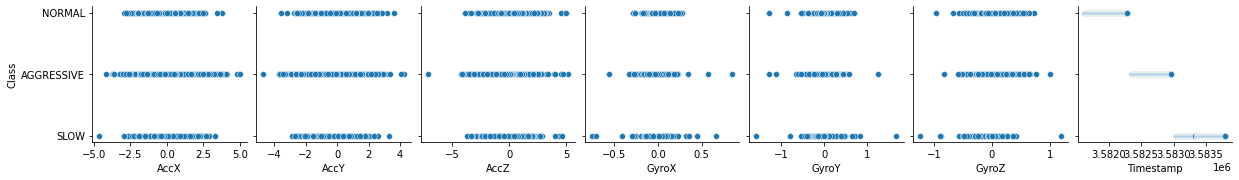

In [205]:
sns.pairplot(
    t_train,
    x_vars=["AccX", "AccY", "AccZ",  "GyroX", "GyroY", "GyroZ", "Timestamp"],
    y_vars=["Class"],
)
plt.show()

Para poder analizar todas las columnas los valores categóricos serán codificados.

In [206]:
t_trainNum = t_train.replace({"Class":  {"SLOW":1, "NORMAL":2, "AGGRESSIVE":3} })
t_train_x = t_train[['AccX',	'AccY',	'AccZ',	'GyroX',	'GyroY',	'GyroZ']]

# Outliers

### IQR score

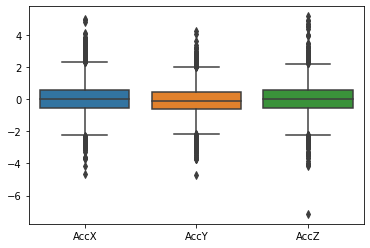

In [207]:
sns.boxplot(data=t_train[['AccX',	'AccY',	'AccZ']])

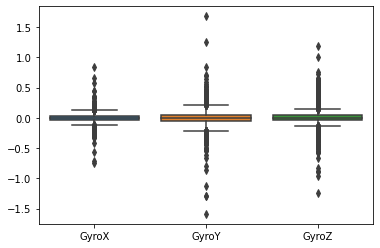

In [208]:
sns.boxplot(data=t_train[['GyroX',	'GyroY',	'GyroZ']])


In [209]:
Q1 = t_train_x.quantile(0.25)
Q3 = t_train_x.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AccX     1.146683
AccY     1.044940
AccZ     1.114620
GyroX    0.060476
GyroY    0.105069
GyroZ    0.070249
dtype: float64


In [210]:
t_trainIQR = t_train[((t_train_x > (Q1 - 1.5 * IQR)) & (t_train_x < (Q3 + 1.5 * IQR))).all(axis=1)]

print("t_train", t_train.shape)
print("t_trainIQR", t_trainIQR.shape)

t_train (3644, 8)
t_trainIQR (2808, 8)


### Z-value

In [211]:
t_trainZ = np.abs(stats.zscore(t_trainNum))
threshold = 3

t_trainZ = t_train[(t_trainZ < threshold).all(axis=1)]
print("t_train", t_train.shape)
print("t_trainZ", t_trainZ.shape)


t_train (3644, 8)
t_trainZ (3395, 8)


In [212]:
t_trainZ.iloc[59]

AccX         0.701135
AccY        -0.168739
AccZ         2.000567
GyroX         0.11133
GyroY        0.111177
GyroZ        0.013363
Class          NORMAL
Timestamp     3581661
Name: 60, dtype: object

In [213]:
t_trainZNum = t_train.replace({"Class":  {"SLOW":1, "NORMAL":2, "AGGRESSIVE":3} })

# Análisis de datos

Variables independientes:
 - AccX, AccY, AccZ: aceleración en los ejes x, y, z en ($\frac{m}{s^{2}}$).
 - GyroX, GyroY, GyroZ: rotación en los ejes x, y, z en ($\frac{°}{s}$).
 - Timestamp: tiempo en segundos.

Variable dependiente:
 - SLOW, NORMAL, AGGRESSIVE: clasificación de conductores.

In [214]:
# Check the type of each variable de mean, 75%, 50% etc
t_trainZ.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3.395000e+03
mean,0.025985,-0.061830,0.003270,0.001272,-0.001443,0.005536,3.582711e+06
std,0.892328,0.824414,0.892626,0.051155,0.094695,0.076043,6.501382e+02
min,-2.897342,-2.628179,-2.944742,-0.195324,-0.375071,-0.331776,3.581629e+06
25%,-0.535493,-0.582748,-0.550992,-0.026725,-0.051924,-0.027565,3.582111e+06
50%,-0.000051,-0.079775,0.002651,0.001985,-0.001833,0.002367,3.582709e+06
75%,0.560695,0.443677,0.539818,0.030696,0.048869,0.037186,3.583286e+06
max,2.956466,2.635117,2.904272,0.195630,0.373239,0.351171,3.583791e+06


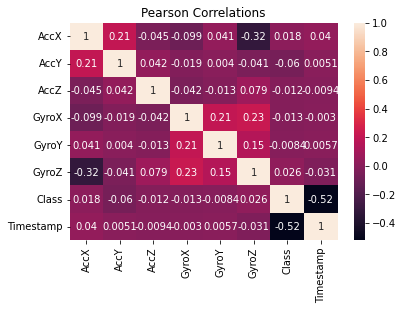

In [215]:
ax = sns.heatmap(t_trainZNum.corr(), annot=True).set(title='Pearson Correlations');

Las variables más correlacionadas entre si son:
 - La clase de manera positiva con AccY y GyroZ.
 - AccX de manera positiva con AccY.
 - GyroX de manera positiva con GyroY y GyroZ.
 - GyroZ negativamente con AccX.

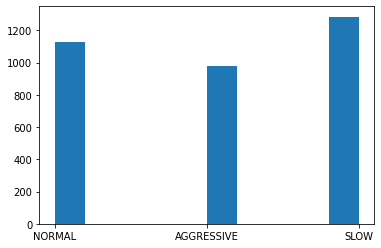

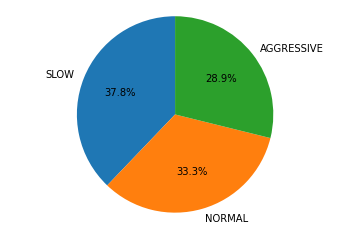

In [216]:
plt.hist(t_trainZ['Class'])

dist = t_trainZ['Class'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(dist, labels=dist.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 

plt.show()

La mayoría de los datos son de la clase SLOW, seguidos por NORMAL y finalizando con AGGRESIVE.

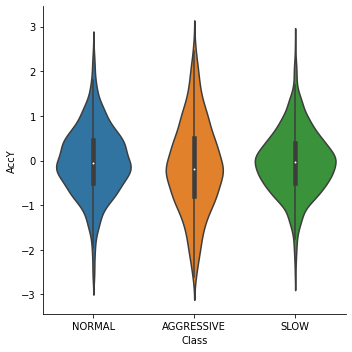

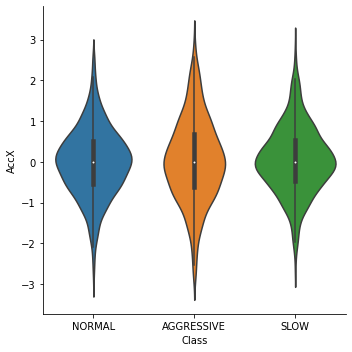

In [217]:
sns.catplot(x='Class', y='AccY', kind='violin', data=t_trainZ)
sns.catplot(x='Class', y='AccX', kind='violin', data=t_trainZ)

En las aceleraciones hacia el frente y lados del carro las clasificaciones tienen más valores alrededor de cero, porque las personas que manejan de manera agresiva cambian de velocidad de manera más abrupta.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


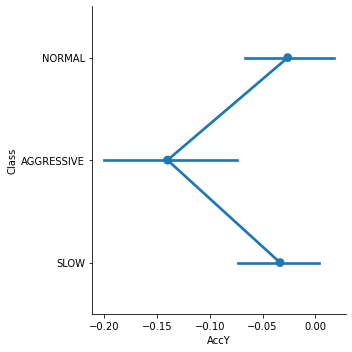

In [219]:
sns.factorplot('AccY', 'Class', data=t_trainZ)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


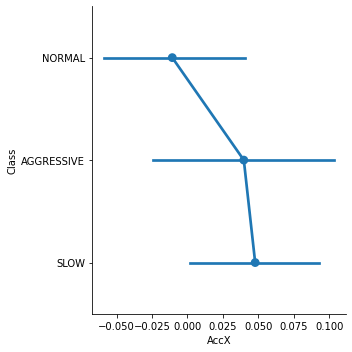

In [220]:
sns.factorplot('AccX', 'Class', data=t_trainZ)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


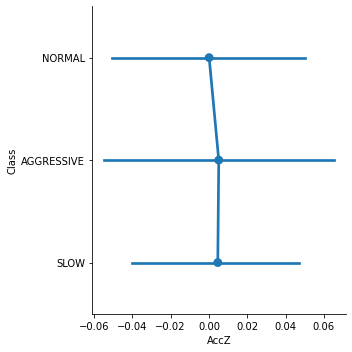

In [221]:
sns.factorplot('AccZ', 'Class', data=t_trainZ)
plt.show()